In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install transformers tqdm boto3 requests regex -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.1 MB/s eta 0:00:00


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
%pip install gputil
%pip install psutil
%pip install humanize

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=8f132c0e37688fb4b5dc94a4f8b18f2a89c0bb324f9ab4d177d2b2a4e791151d
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |  Proc size: "+ humanize.naturalsize(process.memory_info().rss))
  print("GPU RAM FREE: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 52.9 GB  |  Proc size: 99.0 MB
GPU RAM FREE: 15101MB | Used: 0MB | Util   0% | Total 15360MB


In [ ]:
!sudo fuser /dev/nvidia*

In [ ]:
!kill -9 22843

/bin/bash: line 1: kill: (22843) - No such process


In [ ]:
import torch
import random
import pandas as pd
from transformers import BertTokenizer
from IPython.display import clear_output
from google.colab import drive
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.nn.functional import softmax
import gc
from tqdm.notebook import tqdm
import numpy as np
loaded_model = None
total_probabilities = []
total_labels = []
total_probabilities_external = []
total_labels_external = []
total_probabilities_pretrained = []
total_labels_pretrained = []
total_probabilities_pretrained_external = []
total_labels_pretrained_external = []

In [ ]:
# Tokenizer
PRETRAINED_MODEL_NAME = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
clear_output()
print("PyTorch 版本：", torch.__version__)
vocab = tokenizer.vocab
print("字典大小：", len(vocab))

PyTorch 版本： 2.1.0+cu121
字典大小： 21128


In [ ]:
%cd /content/drive/MyDrive/dataset/
%pwd

/content/drive/MyDrive/dataset


'/content/drive/MyDrive/dataset'

In [ ]:
# Data Preprocessing

def count_word(text):
  byte_text = text.encode("utf-8")
  return len(byte_text) // 3

training_df = pd.read_csv('dataset.csv')
init = len(training_df)
index = []
for i in range(len(training_df)):
  if count_word(training_df.at[i, 'Word']) > 20:
    index.append(i)
res = training_df.iloc[index,:]
training_df = training_df.drop(index).copy()

pos_training_df = training_df[training_df['Sentiment'] == 1]
neg_training_df = training_df[training_df['Sentiment'] == 0]
off_training_df = training_df[training_df['Sentiment'] == 2]
SAMPLE_FRAC = 0.8

pos_train = pos_training_df.head(int(SAMPLE_FRAC*len(pos_training_df))).copy()
pos_val = pos_training_df.tail(len(pos_training_df) - int(SAMPLE_FRAC*len(pos_training_df))).copy()

neg_train = neg_training_df.head(int(SAMPLE_FRAC*len(neg_training_df))).copy()
neg_val = neg_training_df.tail(len(neg_training_df) - int(SAMPLE_FRAC*len(neg_training_df))).copy()

off_train = off_training_df.head(int(SAMPLE_FRAC*len(off_training_df))).copy()
off_val = off_training_df.tail(len(off_training_df) - int (SAMPLE_FRAC*len(off_training_df))).copy()

total_train = pd.concat([pos_train, neg_train, off_train], ignore_index=True).reset_index(drop=True)
total_train.to_csv("train.tsv", sep="\t", index=False)
total_valid = pd.concat([pos_val, neg_val, off_val, res], ignore_index=True).reset_index(drop=True)
total_valid.to_csv("valid.tsv", sep="\t", index=False)
print("positive: ", len(pos_train))
print("negative: ", len(neg_train))
print("offensive: ", len(off_train))
print("total train: ", len(total_train))
print("total valid: ", len(total_valid))
print("total data: ", init)

positive:  7697
negative:  9775
offensive:  0
total train:  17472
total valid:  4369
total data:  21841


In [ ]:
print(len(training_df))
print(len(pos_training_df))
print(len(neg_training_df))

21841
9622
12219


In [ ]:
# Data Preprocessing

def count_word(text):
  byte_text = text.encode("utf-8")
  return len(byte_text) // 3

training_df_external = pd.read_csv('dataset_word.csv')
init_external = len(training_df_external)
index_external = []
for i in range(len(training_df_external)):
  if count_word(training_df_external.at[i, 'Word']) > 20:
    index_external.append(i)
res_external = training_df_external.iloc[index_external,:]
training_df_external = training_df_external.drop(index_external).copy()

pos_training_df_external = training_df_external[training_df_external['Sentiment'] == 1]
neg_training_df_external = training_df_external[training_df_external['Sentiment'] == 0]
off_training_df_external = training_df_external[training_df_external['Sentiment'] == 2]
SAMPLE_FRAC = 0.8

pos_train_external = pos_training_df_external.head(int(SAMPLE_FRAC*len(pos_training_df_external))).copy()
pos_val_external = pos_training_df_external.tail(len(pos_training_df_external) - int(SAMPLE_FRAC*len(pos_training_df_external))).copy()

neg_train_external = neg_training_df_external.head(int(SAMPLE_FRAC*len(neg_training_df_external))).copy()
neg_val_external = neg_training_df_external.tail(len(neg_training_df_external) - int(SAMPLE_FRAC*len(neg_training_df_external))).copy()

off_train_external = off_training_df_external.head(int(SAMPLE_FRAC*len(off_training_df_external))).copy()
off_val_external = off_training_df_external.tail(len(off_training_df_external) - int (SAMPLE_FRAC*len(off_training_df_external))).copy()

total_train_external = pd.concat([pos_train_external, neg_train_external, off_train_external], ignore_index=True).reset_index(drop=True)
total_train_external.to_csv("train_external.tsv", sep="\t", index=False)
total_valid_external = pd.concat([pos_val_external, neg_val_external, off_val_external, res_external], ignore_index=True).reset_index(drop=True)
total_valid_external.to_csv("valid_external.tsv", sep="\t", index=False)
print("positive: ", len(pos_train_external))
print("negative: ", len(neg_train_external))
print("offensive: ", len(off_train_external))
print("total train: ", len(total_train_external))
print("total valid: ", len(total_valid_external))
print("total data: ", init_external)

positive:  18624
negative:  27613
offensive:  0
total train:  46237
total valid:  11561
total data:  57798


In [ ]:
# BERT format transformation
from torch.utils.data import Dataset

class BERT_Dataset(Dataset):
    # 讀取前處理後的 tsv 檔並初始化一些參數
    def __init__(self, mode, tokenizer, dataset_mode):
        assert mode in ["train", "test", "valid"]
        self.mode = mode
        if dataset_mode == "internal":
          self.df = pd.read_csv(mode + ".tsv", sep="\t").fillna("").copy()
        elif dataset_mode == "external":
          self.df = pd.read_csv(mode + "_external.tsv", sep="\t").fillna("").copy()
        self.len = len(self.df)
        self.label_map = {0: 0, 1: 1,2: 0}
        self.tokenizer = tokenizer

    # 定義回傳一筆訓練 / 測試數據的函式
    def __getitem__(self, idx):
        if self.mode == "test":
            text = self.df.iloc[idx, 0].values
            label_tensor = None
        else:
            text, label = self.df.iloc[idx, :].values
            # print(text, label)
            # 將 label 文字也轉換成索引方便轉換成 tensor
            label_id = self.label_map[label]
            # print(label_id)
            label_tensor = torch.tensor(label_id)

        # 建立第一個句子的 BERT tokens 並加入分隔符號 [SEP]
        word_pieces = ["[CLS]"]
        tokens = self.tokenizer.tokenize(text)
        word_pieces += tokens + ["[SEP]"]
        len_a = len(word_pieces)

        # 將整個 token 序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        # 將第一句包含 [SEP] 的 token 位置設為 0，其他為 1 表示第二句
        segments_tensor = torch.tensor([0] * len_a,
                                        dtype=torch.long)

        # return (tokens_tensor, segments_tensor, label_tensor)
        return (tokens_tensor, segments_tensor, label_tensor)

    def __len__(self):
        return self.len

trainset = BERT_Dataset("train", tokenizer=tokenizer, dataset_mode="internal")
validset = BERT_Dataset("valid", tokenizer=tokenizer, dataset_mode="internal")
trainset_external = BERT_Dataset("train", tokenizer=tokenizer, dataset_mode="external")
validset_external = BERT_Dataset("valid", tokenizer=tokenizer, dataset_mode="external")

In [ ]:
# BERT format transformation test

# 選擇第一個樣本
sample_idx = 0

# 將原始文本拿出做比較
text, label = trainset.df.iloc[sample_idx, :].values

# 利用剛剛建立的 Dataset 取出轉換後的 id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# 將 tokens_tensor 還原成文本
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = "".join(tokens)

# 渲染前後差異，毫無反應就是個 print。可以直接看輸出結果
print(f"""[原始文本]
vocab: {text}
label: {label}

--------------------

[Dataset 回傳的 tensors]
tokens_tensor: {tokens_tensor}

segments_tensor: {segments_tensor}

label_tensor: {label_tensor}

--------------------

[還原 tokens_tensors]
{combined_text}
""")

[原始文本]
vocab: 交通方便，服務也滿意，周圍環境也不錯
label: 1

--------------------

[Dataset 回傳的 tensors]
tokens_tensor: tensor([ 101,  769, 6858, 3175,  912, 8024, 3302, 1243,  738, 4021, 2692, 8024,
        1453, 1752, 4472, 1862,  738,  679, 7097,  102])

segments_tensor: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

label_tensor: 1

--------------------

[還原 tokens_tensors]
[CLS]交通方便，服務也滿意，周圍環境也不錯[SEP]



In [ ]:
# DataLoader (return mini-batch)
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None

    tokens_tensors = pad_sequence(tokens_tensors,
                                  batch_first=True)
    segments_tensors = pad_sequence(segments_tensors,
                                    batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape,
                                dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)

    return tokens_tensors, segments_tensors, masks_tensors, label_ids

BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                         collate_fn=create_mini_batch, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE,
                         collate_fn=create_mini_batch, shuffle=True)
trainloader_external = DataLoader(trainset_external, batch_size=BATCH_SIZE,
                         collate_fn=create_mini_batch, shuffle=True)
validloader_external = DataLoader(validset_external, batch_size=BATCH_SIZE,
                         collate_fn=create_mini_batch, shuffle=True)

In [ ]:
# DataLoader test
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape}
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")


tokens_tensors.shape   = torch.Size([32, 21])
tensor([[ 101,  677, 1001,  678, 6734,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 5543,  679, 5543, 3976, 3229, 7953, 1557,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 7542, 5682, 3918, 4638, 6132, 3302, 2957, 5682,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101, 7478, 2382, 1962, 1604, 8024, 1456, 6887,  738, 2523, 7676, 8024,
         2972, 5956, 8013,  102,    0,    0,    0,    0,    0],
        [ 101, 1922, 2714,  511,  738, 3760,  943, 7442, 6282,  511,  998, 1606,
         1724, 3613,  102,    0,    0,    0,    0,    0,    0],
        [ 101, 5831, 7030, 2208,  117, 4143, 6506, 5455, 3321, 3300, 1456,  749,
          102,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 101,  671, 4486, 2207, 4638, 4026, 4638, 1168, 5993, 6963, 3221, 8024,
  

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
# Sentiment Analysis Classification
from transformers import BertForSequenceClassification

NUM_LABELS = 2

if loaded_model == None:
  model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)
else:
  model = loaded_model
# model.config.max_position_embeddings = 4096
clear_output()

def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
    progress = tqdm(total=len(dataloader.dataset))

    with torch.no_grad():
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]

            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors,
                            token_type_ids=segments_tensors,
                            attention_mask=masks_tensors)

            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)

            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()

            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
            progress.update(BATCH_SIZE)

    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
_, acc = get_predictions(model, trainloader, compute_acc=True)
print("classification acc:", acc)


device: cuda:0


  0%|          | 0/17472 [00:00<?, ?it/s]

classification acc: 0.46474358974358976


In [ ]:
model.train()

#Adam Optim
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)


EPOCHS = 10
for epoch in range(EPOCHS):

    running_loss = 0.0
    progress = tqdm(total=len(trainloader.dataset))

    for data in trainloader:


        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=tokens_tensors,
                        token_type_ids=segments_tensors,
                        attention_mask=masks_tensors,
                        labels=labels)

        loss = outputs[0]
        # backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress.update(BATCH_SIZE)

    _, acc = get_predictions(model, trainloader, compute_acc=True)
    checkpoint = {
    'model_state_dict': model.state_dict(),
    'tokenizer': tokenizer,
    # Add other relevant information as needed
    }
    # torch.save(checkpoint, 'fine_tuned_bert_model.pth')
    torch.save(checkpoint, 'fine_tuned_bert_model_external.pth')


    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss, acc))

  0%|          | 0/46237 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# Prediction
predictions, acc = get_predictions(model, validloader, compute_acc=True)
print('acc: %.3f' %(acc))
print(predictions)

  0%|          | 0/11561 [00:00<?, ?it/s]

acc: 0.619
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')


In [ ]:
# Load the saved model

# loaded_model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS, max_position_embeddings = 4096, ignore_mismatched_sizes=True)
loaded_model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

# Modify the number of classes in the last layer
num_classes = 2  # Change this to the correct number of classes
loaded_model.config.num_labels = num_classes
loaded_model.classifier = torch.nn.Linear(loaded_model.config.hidden_size, num_classes)


# checkpoint = torch.load('fine_tuned_bert_model.pth', map_location=device)
checkpoint = torch.load('fine_tuned_bert_model.pth', map_location=device)
# checkpoint = torch.load('/content/drive/MyDrive/charlie/bert_cla.ckpt', map_location=device)

# Load model and tokenizer
loaded_model.load_state_dict(checkpoint['model_state_dict'])
# loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/charlie/bert_cla.ckpt'))
loaded_tokenizer = checkpoint['tokenizer']
# loaded_tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Prediction
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score# get predict result
import torch.nn as nn

total_probabilities = []
total_labels = []
total_probabilities_external = []
total_labels_external = []
total_probabilities_pretrained = []
total_labels_pretrained = []
total_probabilities_pretrained_external = []
total_labels_pretrained_external = []


def get_pred(logits):
    y_pred = torch.argmax(logits, dim = 1)
    return y_pred

# calculate confusion metrics
def cal_metrics(pred, ans, method):
    '''
    Parameter
    ---------
    pred: [list], predict class
    ans: [list], true class
    method: 'micro', 'weighted', 'macro'.
    ---------
    '''
    if pred.get_device() != 'cpu':
        pred = pred.detach().cpu().numpy()
    if ans.get_device() != 'cpu':
        ans = ans.detach().cpu().numpy()
        
    rec = recall_score(pred, ans, average=method, zero_division=0)
    f1 = f1_score(pred, ans, average=method, zero_division=0)
    prec = precision_score(pred, ans, average=method, zero_division=0)
    acc = accuracy_score(pred, ans)
    return acc, f1, rec, prec

def evaluate(model, data_loader, device, dataset_mode):
    val_loss, val_acc, val_f1, val_rec, val_prec = 0.0, 0.0, 0.0, 0.0, 0.0
    step_count = 0
    loss_fct = nn.CrossEntropyLoss()
    model.eval()

    with torch.no_grad():
        for data in data_loader:

            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]

            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            labels = data[3]
            outputs = model(input_ids=tokens_tensors,
                            token_type_ids=segments_tensors,
                            attention_mask=masks_tensors)

            x = softmax(outputs.logits, dim=1)[:, 1].squeeze().tolist()
            y = labels.tolist()

            if dataset_mode == 1:
              total_probabilities.extend(x)
              total_labels.extend(y)
            if dataset_mode == 2:
              total_probabilities_external.extend(x)
              total_labels_external.extend(y)
            if dataset_mode == 3:
              total_probabilities_pretrained.extend(x)
              total_labels_pretrained.extend(y)
            if dataset_mode == 4:
              total_probabilities_pretrained_external.extend(x)
              total_labels_pretrained_external.extend(y)

            acc, f1, rec, prec = cal_metrics(get_pred(outputs[0].data), labels, 'macro')
            loss = loss_fct(outputs[0].data, labels) # 直接丟就好，不用特意做轉換（但如果非二分類，需考慮 one-hot 標籤的轉換）

            val_loss += loss.item()
            val_acc += acc
            val_f1 += f1
            val_rec += rec
            val_prec += prec
            step_count+=1

        val_loss = val_loss / step_count
        val_acc = val_acc / step_count
        val_f1 = val_f1 / step_count
        val_rec = val_rec / step_count
        val_prec = val_prec / step_count

    return val_loss, val_acc, val_f1, val_rec, val_prec


val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(loaded_model, validloader, device, 1)
# val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, validloader, device)
print('cross entropy: %.3f' %(val_loss))
print("accuracy: %.3f" %(val_acc))
print("f1 score: %.3f" %(val_f1))
print("recall score: %.3f" %(val_rec))
print("precision score: %.3f" %(val_prec))
print(len(total_labels))
print(len(total_probabilities))
print("====================")
val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(loaded_model, validloader_external, device, 2)
# val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, validloader, device)
print('cross entropy: %.3f' %(val_loss))
print("accuracy: %.3f" %(val_acc))
print("f1 score: %.3f" %(val_f1))
print("recall score: %.3f" %(val_rec))
print("precision score: %.3f" %(val_prec))
print(len(total_labels_external))
print(len(total_probabilities_external))
print("====================")
val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, validloader, device, 3)
# val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, validloader, device)
print('cross entropy: %.3f' %(val_loss))
print("accuracy: %.3f" %(val_acc))
print("f1 score: %.3f" %(val_f1))
print("recall score: %.3f" %(val_rec))
print("precision score: %.3f" %(val_prec))
print(len(total_labels_pretrained))
print(len(total_probabilities_pretrained))
print("====================")
val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, validloader_external, device, 4)
# val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, validloader, device)
print('cross entropy: %.3f' %(val_loss))
print("accuracy: %.3f" %(val_acc))
print("f1 score: %.3f" %(val_f1))
print("recall score: %.3f" %(val_rec))
print("precision score: %.3f" %(val_prec))
print(len(total_labels_pretrained_external))
print(len(total_probabilities_pretrained_external))

cross entropy: 0.383
accuracy: 0.874
f1 score: 0.867
recall score: 0.875
precision score: 0.869
4369
4369
cross entropy: 0.595
accuracy: 0.784
f1 score: 0.758
recall score: 0.789
precision score: 0.757
11561
11561
cross entropy: 0.771
accuracy: 0.459
f1 score: 0.382
recall score: 0.505
precision score: 0.505
4369
4369
cross entropy: 0.795
accuracy: 0.412
f1 score: 0.338
recall score: 0.459
precision score: 0.493
11561
11561


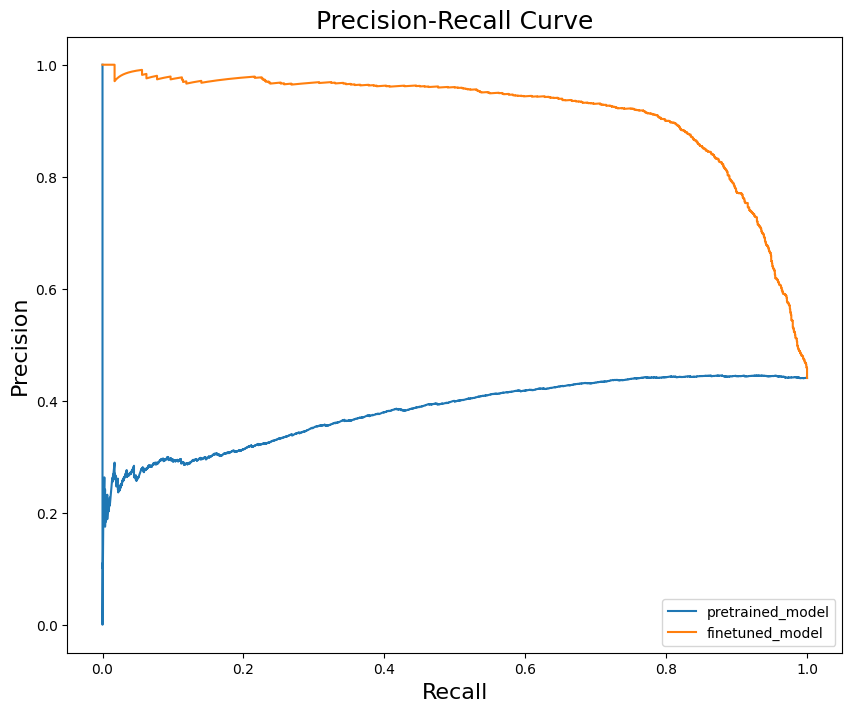

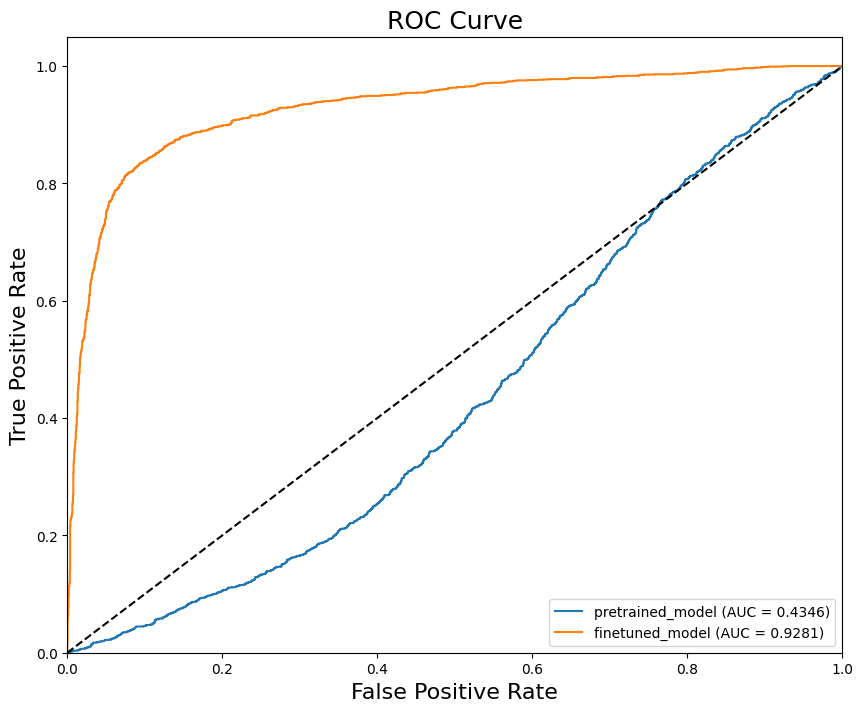

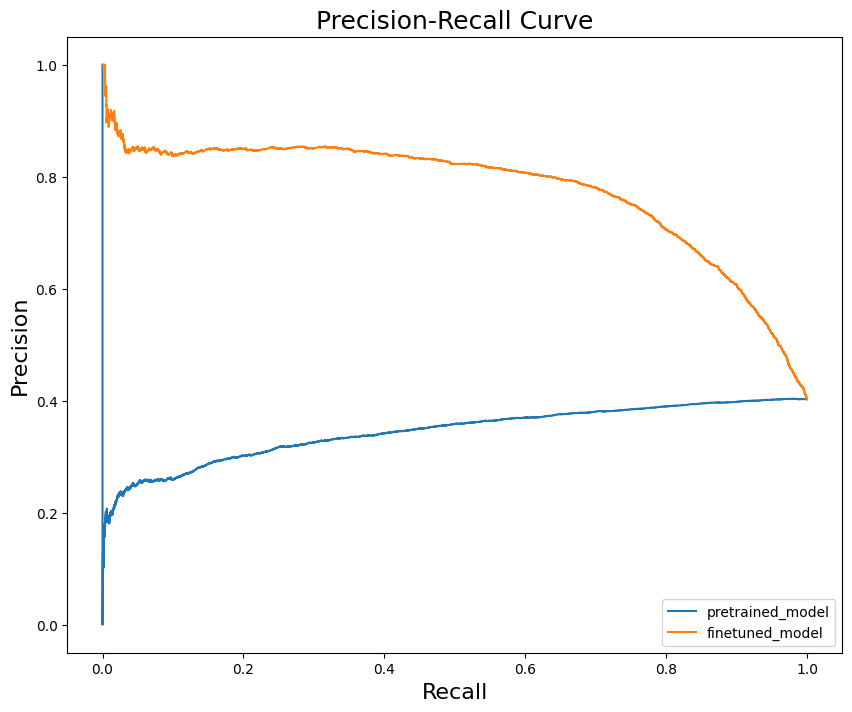

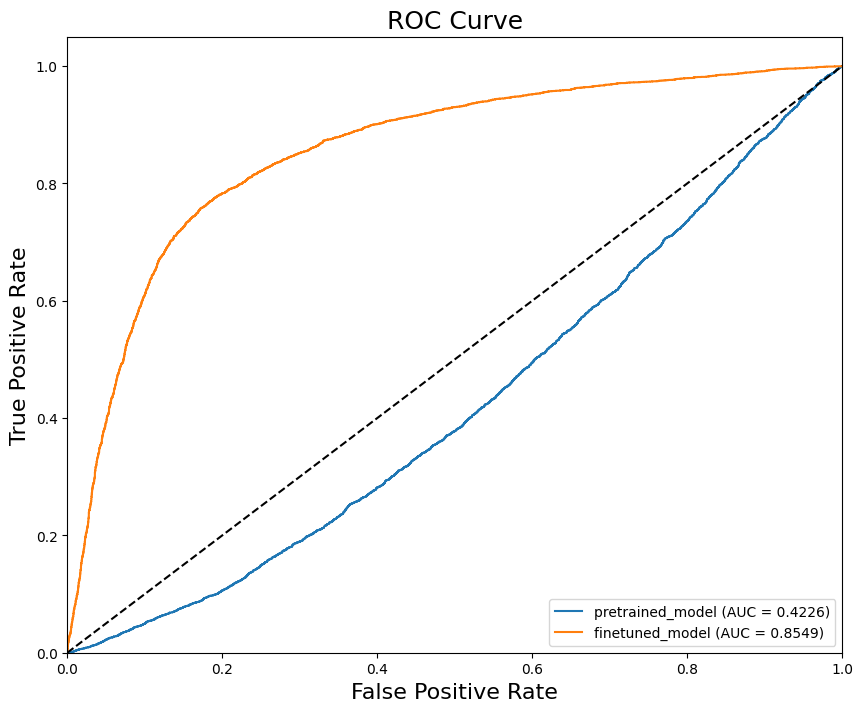

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import os

def plot_roc_curve(model_data, plot_path):
    plt.figure(figsize=(10, 8))

    for model_name, true_labels, predicted_scores in model_data:
      fpr, tpr, threshold = roc_curve(true_labels, predicted_scores)

      auc_value = auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_value:.4f})')

    # Plot ROC curve details
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curve', fontsize=18)
    plt.legend(loc='lower right')
    # plt.savefig(os.path.join(plot_path, 'BERT_ROC_CURVE_internal.png'))
    # plt.close()

def plot_pr_curve(model_data, plot_path):
    plt.figure(figsize=(10, 8))

    for item in model_data:
      model_name, true_labels, predicted_scores = item
      precision, recall, _ = precision_recall_curve(true_labels, predicted_scores)

        # Plot PR curve
      plt.plot(recall, precision, label=model_name)

    # Plot PR curve details
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('Precision-Recall Curve', fontsize=18)
    plt.legend(loc='lower right')
    # plt.savefig(os.path.join(plot_path, 'BERT_PR_CURVE_internal.png'))
    # plt.close()

# print(len(total_labels))
# print(len(total_probabilities))
x = [("pretrained_model", total_labels_pretrained, total_probabilities_pretrained),
 ("finetuned_model", total_labels, total_probabilities)] #internal
y = [("pretrained_model", total_labels_pretrained_external, total_probabilities_pretrained_external),
 ("finetuned_model", total_labels_external, total_probabilities_external)] #external
plot_pr_curve(model_data=x, plot_path='./')
plot_roc_curve(model_data=x, plot_path='./')
plot_pr_curve(model_data=y, plot_path='./')
plot_roc_curve(model_data=y, plot_path='./')
# plot_pr_curve(total_labels, total_probabilities, './')
# plot_roc_curve(total_labels, total_probabilities, './')

In [ ]:
# Example sentence for prediction
input_sentence = "白痴, 肥, 一帆風順, 去死"

# Preprocess the text
tokens = loaded_tokenizer.encode_plus(
    input_sentence,
    add_special_tokens=True,
    return_tensors='pt',
    truncation=True,
    max_length=512  # Adjust based on your model's maximum input length
)

# Make predictions
with torch.no_grad():
    outputs = loaded_model(**tokens)

logits = outputs.logits
probabilities = softmax(logits, dim=1)
predicted_class = torch.argmax(probabilities).item()

# Map predicted class index to label (positive, negative, offensive)
class_labels = ["Negative", "Positive", "Offensive"]
predicted_label = class_labels[predicted_class]

print(f"{input_sentence}: {predicted_label}")


RuntimeError: ignored

In [ ]:
import torch
from torch.nn.functional import softmax
from transformers import BertTokenizer, BertForSequenceClassification

def load_checkpoint(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

def predict_single_sentence(model, sentence, tokenizer):
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = softmax(logits, dim=1).squeeze().tolist()

    return probabilities

# Load the checkpoint and tokenizer
# model = BertForSequenceClassification.from_pretrained('bert-base-chinese')
# checkpoint_path = 'bert_cla.ckpt'  # Replace with the actual path
# load_checkpoint(model, checkpoint_path)

# tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')



In [ ]:
# Example usage
loaded_model = loaded_model.to(device)
input_sentence = "您的留言暴露了 你自己本身就是地域歧視者和種族歧視者 這很沙雕。 所以就“心安理得”接受了白人歧視亞裔的客觀情況。還自鳴得意的諷刺不認同任何種族歧視行爲的同胞 矯情。這波操作太6了，建議您真的需要去看看心理醫生， 精澳真的是病。"
predicted_probabilities = predict_single_sentence(loaded_model, input_sentence, loaded_tokenizer)

print("Predicted Probabilities:")
for class_idx, prob in enumerate(predicted_probabilities):
    print(f"Class {class_idx}: {prob:.4f}")


RuntimeError: ignored